# Reinforcement method on CartPole (PyTorch)

In this notebook Reinforcement method is applied for CartPole environment from OpenAI gym, with PyTorch. Reinforcement method is :

*   policy-based method
*   on-policy method

The code is based on the book: Deep Reinforcement Learning Hands-On, 2nd edition, from Packt publishing, by Maxim Lapan. The original code is taken from the GitHub pages of the book, and perhaps modified in some places.


## 1. Import packages

In [3]:
# Install PyTorch Agent Net (PTAN) library.
# That contains elements beneficial for RL, eg Agent, ActionSelector, ExperienceSource etc.
pip install ptan==0.7

  Created wheel for ptan: filename=ptan-0.7-cp36-none-any.whl size=23502 sha256=ae86f7e41e83c1ba4d64501a851e67124249a9281dd9c2684ac009bd6048d1dc
  Stored in directory: /root/.cache/pip/wheels/2c/58/0c/a42dad12a5cc0e130453042707b3e2205adfb901ae35cfad75
Successfully built ptan


In [4]:
import gym
import ptan
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## 2. Build the model

In [6]:
GAMMA = 0.99
LEARNING_RATE = 0.01
EPISODES_TO_TRAIN = 4

In [7]:
# The output of the NN is logits
# This is since log_softmax is rather calculated at once in the training section
class PGN(nn.Module):
    def __init__(self, input_size, n_actions):
        super(PGN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)

## 3. Define function calculating Q(s,a) values for an episode

In [10]:
# The function calculates the discounted reward for every step
# Input is a list of rewards for one episode
# Since q values are used as a scaling factor for actions in training, the mean of q values is subtracted from each q.
# This reduces high variance in the q values
def calc_qvals(rewards):
    res = []
    sum_r = 0.0
    for r in reversed(rewards):
        sum_r *= GAMMA
        sum_r += r
        res.append(sum_r)
    res = res[::-1]
    mean_q = np.mean(res)
    return [q - mean_q for q in res]

## 4. Play the game and train the network

In [12]:
# Ptan modules:
# - Agent uses the NN to get action probabilities based on the state from env,
#   and makes selection of the actions based on probabilities
# - Experience source returns s,a,r,s' transitions that agent creates on env
#    note, there can be steps_count steps between s and s' (here it is 1)
env = gym.make("CartPole-v0")
net = PGN(env.observation_space.shape[0], env.action_space.n)
print(net)

agent = ptan.agent.PolicyAgent(net, preprocessor=ptan.agent.float32_preprocessor,
                                apply_softmax=True)
# Gym returns float64, but PyTorch requires float32, so it is casted to that

exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA)
# for the ExperienceSourceFirstLast the steps_count=1, i.e. the default value
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

total_rewards = []
step_idx = 0
done_episodes = 0

batch_episodes = 0
batch_states, batch_actions, batch_qvals = [], [], []
cur_states, cur_actions, cur_rewards = [], [], []

losses=[]
reward_means=[]

for step_idx, exp in enumerate(exp_source):
    cur_states.append(exp.state)
    cur_actions.append(int(exp.action))
    cur_rewards.append(exp.reward)

    if exp.last_state is None: # episode ends
        batch_states.extend(cur_states)
        batch_actions.extend(cur_actions)
        batch_qvals.extend(calc_qvals(cur_rewards))
        cur_states.clear()
        cur_actions.clear()
        cur_rewards.clear()
        batch_episodes += 1

    # handle new rewards, if episode has ended
    # exp_source.pop_total_rewards returns none if episode has not ended
    # otherwise it returns total reward for the ended episode
    new_rewards = exp_source.pop_total_rewards()
    if new_rewards: 
        done_episodes += 1
        reward = new_rewards[0]
        total_rewards.append(reward)
        # calculate mean of the last 100 total rewards
        mean_reward = float(np.mean(total_rewards[-100:]))
        reward_means.append(mean_reward)

        print(f"{step_idx}: reward={reward:6.2f}, mean_100={mean_reward:6.2f}, episodes={done_episodes}")
        if mean_reward > 195:
            #print("Solved in %d steps and %d episodes!" % (step_idx, done_episodes))
            print(f"Solved in {step_idx} steps and {done_episodes} episodes!")
            break

    if batch_episodes < EPISODES_TO_TRAIN:
        continue

    states_v = torch.FloatTensor(batch_states)
    batch_actions_t = torch.LongTensor(batch_actions)
    batch_qvals_v = torch.FloatTensor(batch_qvals)

    optimizer.zero_grad()
    logits_v = net(states_v)
    log_prob_v = F.log_softmax(logits_v, dim=1)
    # Note here batch_qvals_v contain the idea that mean qval is subtracted from qvals for each episode
    # That reduces variance of scaling of the actions
    log_prob_actions_v = batch_qvals_v * log_prob_v[range(len(batch_states)), batch_actions_t]
    loss_v = -log_prob_actions_v.mean()
    losses.append(loss_v.item())
    
    loss_v.backward()
    optimizer.step()

    batch_episodes = 0
    batch_states.clear()
    batch_actions.clear()
    batch_qvals.clear()

PGN(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)
30: reward= 30.00, mean_100= 30.00, episodes=1
47: reward= 17.00, mean_100= 23.50, episodes=2
73: reward= 26.00, mean_100= 24.33, episodes=3
99: reward= 26.00, mean_100= 24.75, episodes=4
112: reward= 13.00, mean_100= 22.40, episodes=5
127: reward= 15.00, mean_100= 21.17, episodes=6
138: reward= 11.00, mean_100= 19.71, episodes=7
153: reward= 15.00, mean_100= 19.12, episodes=8
162: reward=  9.00, mean_100= 18.00, episodes=9
220: reward= 58.00, mean_100= 22.00, episodes=10
240: reward= 20.00, mean_100= 21.82, episodes=11
270: reward= 30.00, mean_100= 22.50, episodes=12
280: reward= 10.00, mean_100= 21.54, episodes=13
291: reward= 11.00, mean_100= 20.79, episodes=14
312: reward= 21.00, mean_100= 20.80, episodes=15
339: reward= 27.00, mean_100= 21.19, episodes=16
348: reward=  9.00, mean_100= 20.47, episodes=17
359: reward=

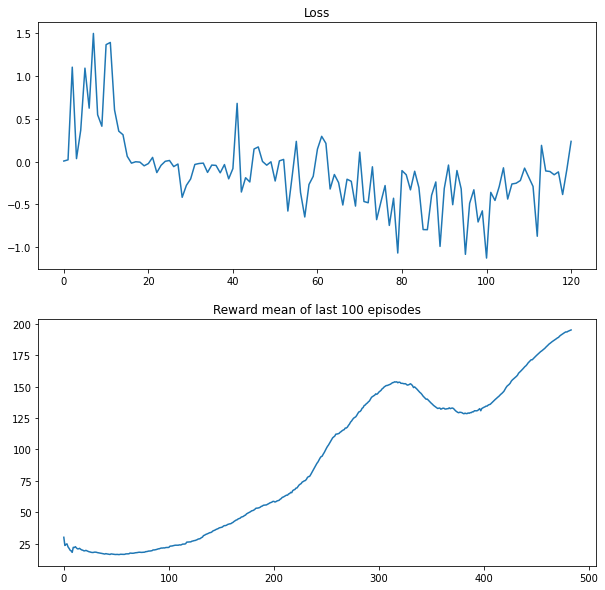

In [14]:
plt.figure(figsize=(10, 10))
charts=[losses,reward_means]
titles=['Loss','Reward mean of last 100 episodes']
for i, (chart, title) in enumerate(zip(charts,titles)):
  ax=plt.subplot(2,1,i+1)
  plt.plot(chart)
  plt.title(title)